In [36]:
import os
import glob
import pickle
import time
import json

os.environ["PRIVBAYES_BIN"] = "./ydnpd/harness/synthesis/privbayes/mac_bin"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, Markdown


import ydnpd
from additional import ADDITIONAL_EXPERIMENTS, ADDITIONAL_PATH
from ydnpd import EVALUATION_METRICS, ALL_EXPERIMENTS, Experiments

ADDITIONAL_DATASETS = sum(list(ADDITIONAL_EXPERIMENTS.values()), [])

with open("./results/harness.pkl", "rb") as f:
    utility_tasks_results = pickle.load(f)

with open("./results/harness-epsilon-2.pkl", "rb") as f:
    more_utility_tasks_results = pickle.load(f)

# merge the two dicts
utility_tasks_results = utility_tasks_results + more_utility_tasks_results


for x in utility_tasks_results:
    if type(x["evaluation"]["error_rate_diff"]) == list:
        assert len(x["evaluation"]["error_rate_diff"]) == 1
        x["evaluation"]["error_rate_diff"] = x["evaluation"]["error_rate_diff"][0]

In [37]:
# keep only results where dataset name contains "acs"
# acs_results = [x for x in utility_tasks_results if "acs" in x["dataset_name"].lower()]
utility_tasks_results = utility_tasks_results
# also get rid of results where synth is gem
utility_tasks_results = [x for x in utility_tasks_results if x["synth_name"] != "gem"]

In [38]:
# check which metrics are nan for which datasets
# NOTE: there are some datasets for which there are more nans. we will just not include...
missing_metrics = {}
for x in utility_tasks_results:
    for metric in EVALUATION_METRICS:
        if np.isnan(x["evaluation"][metric]):
            missing_metrics[x["dataset_name"]] = missing_metrics.get(x["dataset_name"], []) + [metric]

In [39]:
all_results = utility_tasks_results.copy()

reference_data_mapping = {
    "acs": "acs/national",
    "edad": "edad/2023",
    "we": "we/2023",
}

METRIC_DIRECTION = {
    "error_rate_diff": "closer_to_zero_is_better",
    "aoc_diff": "closer_to_zero_is_better",
    "marginals_3_max_abs_diff_error": "closer_to_zero_is_better",
    "marginals_3_avg_abs_diff_error": "closer_to_zero_is_better",
    "thresholded_marginals_3_max_abs_diff_error": "closer_to_zero_is_better",
    "thresholded_marginals_3_avg_abs_diff_error": "closer_to_zero_is_better",
    "total_variation_distance": "closer_to_zero_is_better",
    "pearson_corr_max_abs_diff": "closer_to_zero_is_better",
    "pearson_corr_avg_abs_diff": "closer_to_zero_is_better",
    "cramer_v_corr_max_abs_diff": "closer_to_zero_is_better",
    "cramer_v_corr_avg_abs_diff": "closer_to_zero_is_better",
}
    
    
CORRELATION_METRICS = [
    "total_variation_distance",
    "pearson_corr_max_abs_diff",
    "pearson_corr_avg_abs_diff",
    "cramer_v_corr_max_abs_diff",
    "cramer_v_corr_avg_abs_diff",
]
MARGINALS_METRICS = [
    "marginals_3_max_abs_diff_error",
    "marginals_3_avg_abs_diff_error",
    "thresholded_marginals_3_max_abs_diff_error",
    "thresholded_marginals_3_avg_abs_diff_error",
]
CLASSIFICATION_METRICS = [
    "error_rate_diff",
    "aoc_diff",
]

df = pd.DataFrame(all_results)

df_evaluation = pd.json_normalize(df["evaluation"])

def dict_to_sorted_json_str(d):
    return str(json.dumps(d, sort_keys=True)) # str(

df["hparams_str"] = df["hparams"].apply(dict_to_sorted_json_str)

df_combined = pd.concat(
    [df.drop(columns=["hparams", "evaluation"]),
     df_evaluation],
    axis=1
)

# group by hparams_str, take the mean
df_combined = df_combined[['hparams_str', 'synth_name', 'epsilon', 'dataset_name'] + list(METRIC_DIRECTION.keys())].groupby(['hparams_str', 'synth_name', 'epsilon', 'dataset_name']).mean().reset_index()

def get_reference_dataset_name(ds_name):
    if ds_name.startswith("acs/"):
        return reference_data_mapping["acs"]
    elif ds_name.startswith("edad/"):
        return reference_data_mapping["edad"]
    elif ds_name.startswith("we/"):
        return reference_data_mapping["we"]
    else:
        raise ValueError(f"unknown dataset name {ds_name}")

df_combined["reference_dataset_name"] = df_combined["dataset_name"].apply(get_reference_dataset_name)

def find_best_performance_rows(subdf, metric):
    direction = METRIC_DIRECTION[metric]
    if direction == "closer_to_zero_is_better":
        best_val = subdf[metric].abs().min()
        best_hparams_str = subdf[subdf[metric].abs() == best_val]["hparams_str"].iloc[0]
        return subdf[subdf[metric].abs() == best_val], best_hparams_str
    else:
        raise ValueError(f"everything is closer_to_zero_is_better now")
    
rows_for_report = []

# skipped tracker
skipped = {}
group_cols = ["synth_name", "epsilon", "reference_dataset_name"]
for (synth_name, epsilon, reference_dataset_name), group_df in df_combined.groupby(group_cols):
    # identify the reference dataset within this group
    ref_df = group_df[group_df["dataset_name"] == reference_dataset_name]
    if ref_df.empty:
        continue

    # find the 'true best performance' for each metric in that reference subset
    true_best_performance = {}
    for metric in METRIC_DIRECTION.keys():
        best_rows, best_hparams = find_best_performance_rows(ref_df, metric)
        # just pick the first row in case of tie
        best_row = best_rows.iloc[0]
        true_best_val = np.abs(best_row[metric])
        true_best_performance[metric] = (true_best_val, best_row, best_hparams)

    # for each dataset in the group, figure out which hyperparams you'd pick
    for ds_name, ds_group_df in group_df.groupby("dataset_name"):

        # then do that for each metric (or each metric block)
        for metric in METRIC_DIRECTION.keys():
            try:
                best_ds_rows, _ = find_best_performance_rows(ds_group_df, metric)
                chosen_row = best_ds_rows.iloc[0]  # pick first in tie
                chosen_hparams_str = chosen_row["hparams_str"]

                # now we see if that same hparams_str is present in the reference df
                ref_match = ref_df[ref_df["hparams_str"] == chosen_hparams_str]
                if ref_match.empty:
                    # means reference never had that exact set of hyperparams
                    raise ValueError(f"reference dataset has no hyperparams {chosen_hparams_str} for metric {metric}")

                # how does it perform on the reference dataset?
                row_in_ref = ref_match.iloc[0]
                perf_on_ref = np.abs(row_in_ref[metric])

                # get the "true best" value for that metric
                (true_best_val, _, best_hparams) = true_best_performance[metric]

                # define percent_degradation = (candidate - best) / abs(best), if best != 0, else 0
                if true_best_val == 0:
                    pct_degradation = 0
                else:
                    pct_degradation = (perf_on_ref - true_best_val) / abs(true_best_val)

                # store in our report
                rows_for_report.append({
                    "synth_name": synth_name,
                    "epsilon": epsilon,
                    "dataset_name": ds_name,
                    "metric": metric,
                    "chosen_hparams_str": chosen_hparams_str,
                    "chosen_val_on_dataset": np.abs(chosen_row[metric]),
                    "perf_on_reference": perf_on_ref,
                    "true_best_on_reference": true_best_val,
                    "pct_degradation_on_ref": pct_degradation,
                    "best_hparams": best_hparams,
                    "reference_dataset_name": reference_dataset_name,
                })
            except Exception as e:
                print(f"skipping {synth_name}, {epsilon}, {ds_name}, {metric}: {e}")
                if (synth_name, epsilon, ds_name, metric) not in skipped:
                    skipped[(synth_name, epsilon, ds_name, metric)] = 0
                skipped[(synth_name, epsilon, ds_name, metric)] += 1


report_df = pd.DataFrame(rows_for_report)

METRIC_GROUPS = {
    "marginals_metrics": [
        "marginals_3_max_abs_diff_error",
        "marginals_3_avg_abs_diff_error",
        "thresholded_marginals_3_max_abs_diff_error",
        "thresholded_marginals_3_avg_abs_diff_error",
    ],
    "classification_metrics": [
        "error_rate_diff",
        "aoc_diff",
    ],
    "correlation_metrics": [
        "total_variation_distance",
        "pearson_corr_max_abs_diff",
        "pearson_corr_avg_abs_diff",
        "cramer_v_corr_max_abs_diff",
        "cramer_v_corr_avg_abs_diff",
    ],
}

# reverse mapping, metric -> group
metric_to_group = {}
for group, metrics in METRIC_GROUPS.items():
    for metric in metrics:
        metric_to_group[metric] = group

# metric_group to column to report_df
report_df['metric_group'] = report_df['metric'].map(metric_to_group)


skipping aim_jax, 1, edad/gen-llama-MIX-MAX, error_rate_diff: single positional indexer is out-of-bounds
skipping aim_jax, 1, edad/gen-llama-MIX-MAX, aoc_diff: single positional indexer is out-of-bounds
skipping aim_jax, 1, edad/gen-llama-MIX-UNIF, error_rate_diff: single positional indexer is out-of-bounds
skipping aim_jax, 1, edad/gen-llama-MIX-UNIF, aoc_diff: single positional indexer is out-of-bounds
skipping aim_jax, 2, edad/gen-llama-MIX-MAX, error_rate_diff: single positional indexer is out-of-bounds
skipping aim_jax, 2, edad/gen-llama-MIX-MAX, aoc_diff: single positional indexer is out-of-bounds
skipping aim_jax, 2, edad/gen-llama-MIX-UNIF, error_rate_diff: single positional indexer is out-of-bounds
skipping aim_jax, 2, edad/gen-llama-MIX-UNIF, aoc_diff: single positional indexer is out-of-bounds
skipping aim_jax, 4, edad/gen-llama-MIX-MAX, error_rate_diff: single positional indexer is out-of-bounds
skipping aim_jax, 4, edad/gen-llama-MIX-MAX, aoc_diff: single positional indexe

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

metric_group_map = {
    "correlation_metrics": "Correlation",
    "classification_metrics": "Classification",
    "marginals_metrics": "Marginals"
}

we_method_name_map = {
    "we/2018": "2018",
    "we/2023": "2023",
    "we/arbitrary": "Arbitrary (Baseline)",
    "we/baseline_domain": "Domain (Baseline)",
    "we/baseline_univariate": "Univariate (Baseline)",
    "we/csv-claude": "CSV (Claude)",
    "we/csv-gpt": "CSV (GPT)",
    "we/csv-llama": "CSV (LLaMA)",
    "we/gen-MIX-MAX": "Gen. (MIX-MAX)",
    "we/gen-MIX-UNIF": "Gen. (MIX-UNIF)",
    "we/gen-claude-MIX-MAX": "Gen. (Claude MIX-MAX)",
    "we/gen-claude-MIX-UNIF": "Gen. (Claude MIX-UNIF)",
    "we/gen-gpt-MIX-MAX": "Gen. (GPT MIX-MAX)",
    "we/gen-gpt-MIX-UNIF": "Gen. (GPT MIX-UNIF)",
    "we/gen-llama-MIX-MAX": "Gen. (LLaMA MIX-MAX)",
    "we/gen-llama-MIX-UNIF": "Gen. (LLaMA MIX-UNIF)",
    "we/sdscm-gpt2": "SDSCM (GPT-2)",
    "we/sdscm-llama-3-8b": "SDSCM (LLaMA-3 8B)",
    "we/sdscm-olmo-1b-hf": "SDSCM (OLMO-1B HF)"
}

acs_method_name_map = {
    "acs/arbitrary": "Arbitrary (Baseline)",
    "acs/baseline_domain": "Domain (Baseline)",
    "acs/baseline_univariate": "Univariate (Baseline)",
    "acs/csv-claude": "CSV (Claude)",
    "acs/csv-gpt": "CSV (GPT)",
    "acs/csv-llama": "CSV (LLaMA)",
    "acs/gen-MIX-MAX": "Gen. (MIX-MAX)",
    "acs/gen-MIX-UNIF": "Gen. (MIX-UNIF)",
    "acs/gen-claude-MIX-MAX": "Gen. (Claude MIX-MAX)",
    "acs/gen-claude-MIX-UNIF": "Gen. (Claude MIX-UNIF)",
    "acs/gen-gpt-MIX-MAX": "Gen. (GPT MIX-MAX)",
    "acs/gen-gpt-MIX-UNIF": "Gen. (GPT MIX-UNIF)",
    "acs/gen-llama-MIX-MAX": "Gen. (LLaMA MIX-MAX)",
    "acs/gen-llama-MIX-UNIF": "Gen. (LLaMA MIX-UNIF)",
    "acs/massachusetts_upsampled": "Massachusetts",
    "acs/national": "National",
    "acs/sdscm-gpt2": "SDSCM (GPT-2)",
    "acs/sdscm-llama-3-8b": "SDSCM (LLaMA-3 8B)",
    "acs/sdscm-olmo-1b-hf": "SDSCM (OLMO-1B HF)"
}

edad_method_name_map = {
    "edad/2020": "2020",
    "edad/2023": "2023",
    "edad/arbitrary": "Arbitrary (Baseline)",
    "edad/baseline_domain": "Domain (Baseline)",
    "edad/baseline_univariate": "Univariate (Baseline)",
    "edad/csv-claude": "CSV (Claude)",
    "edad/csv-gpt": "CSV (GPT)",
    "edad/csv-llama": "CSV (LLaMA)",
    "edad/gen-MIX-MAX": "Gen. (MIX-MAX)",
    "edad/gen-MIX-UNIF": "Gen. (MIX-UNIF)",
    "edad/gen-claude-MIX-MAX": "Gen. (Claude MIX-MAX)",
    "edad/gen-claude-MIX-UNIF": "Gen. (Claude MIX-UNIF)",
    "edad/gen-gpt-MIX-MAX": "Gen. (GPT MIX-MAX)",
    "edad/gen-gpt-MIX-UNIF": "Gen. (GPT MIX-UNIF)",
    "edad/gen-llama-MIX-MAX": "Gen. (LLaMA MIX-MAX)",
    "edad/gen-llama-MIX-UNIF": "Gen. (LLaMA MIX-UNIF)",
    "edad/sdscm-gpt2": "SDSCM (GPT-2)",
    "edad/sdscm-llama-3-8b": "SDSCM (LLaMA-3 8B)",
    "edad/sdscm-olmo-1b-hf": "SDSCM (OLMO-1B HF)"
}

rename_map = {
    "pct_degradation_on_ref": "% Degradation on Ref."
}

method_grouping = {
    "Arbitrary (Baseline)": "Baseline",
    "Domain (Baseline)": "Baseline",
    "Univariate (Baseline)": "Baseline",
    "CSV (Claude)": "CSV",
    "CSV (GPT)": "CSV",
    "CSV (LLaMA)":  "CSV",
    "Gen. (MIX-MAX)": "Gen",
    "Gen. (MIX-UNIF)":  "Gen",
    "Gen. (Claude MIX-MAX)": "Gen",
    "Gen. (Claude MIX-UNIF)": "Gen",
    "Gen. (GPT MIX-MAX)": "Gen",
    "Gen. (GPT MIX-UNIF)": "Gen",
    "Gen. (LLaMA MIX-MAX)": "Gen",
    "Gen. (LLaMA MIX-UNIF)": "Gen",
    "SDSCM (GPT-2)": "SDSCM",
    "SDSCM (LLaMA-3 8B)": "SDSCM",
    "SDSCM (OLMO-1B HF)":  "SDSCM",
}

grouping_colors = {
    # grey color
    "Baseline": "#808080",
    # green
    "CSV": "#008000",
    # orange
    "Gen": "#FFA500",
    # brown
    "SDSCM": "#A52A2A",
    # other should be magenta
    "Other": "#FF00FF"
}

def facet_plot_builder(df, method_name_map):
    df_for_plotting = df.copy()
    with plt.style.context(['science']):
        plt.rc('text', usetex=False)
        long_data = []
        for ds_name in df_for_plotting.index:
            row = df_for_plotting.loc[ds_name]
            
            long_data.append({
                "dataset_name": ds_name,
                "metric_group": "Classification",
                "mean": row["mean_class"],
                "std": row["std_class"],
            })
            long_data.append({
                "dataset_name": ds_name,
                "metric_group": "Correlation",
                "mean": row["mean_corr"],
                "std": row["std_corr"],
            })
            long_data.append({
                "dataset_name": ds_name,
                "metric_group": "Marginals",
                "mean": row["mean_marg"],
                "std": row["std_marg"],
            })

        plot_df = pd.DataFrame(long_data)
        
        plot_df["dataset_name_label"] = plot_df["dataset_name"].map(method_name_map).fillna(plot_df["dataset_name"])

        # trick to get the facet grid sorting right
        plot_df = plot_df.sort_values(by=["metric_group", "mean"], ascending=[True, False])

        plot_df["method_group"] = (
            plot_df["dataset_name_label"]
            .map(method_grouping)
            .fillna("Other")
        )

        g = sns.FacetGrid(
            data=plot_df,
            col="metric_group",
            col_wrap=3,
            sharex=False,
            sharey=False,
            height=5
        )

        # get x-axis limits
        x_min = plot_df["mean"].min()


        def barplot_with_errorbars(data, color=None, label=None, **kwargs):
            ax = plt.gca()
            # We iterate each row and manually draw a horizontal bar
            for idx, row in data.iterrows():
                grp = row["method_group"]
                c = grouping_colors.get(grp, grouping_colors['Other'])  # fallback color
                ax.barh(
                    y=row["dataset_name_label"],
                    width=row["mean"],
                    xerr=row["std"],      # error bar
                    color=c,
                    capsize=0.1
                )

        g.map_dataframe(barplot_with_errorbars)

        for ax in g.axes.flat:
            for label in ax.get_yticklabels():
                label.set_rotation(0)
            ax.set_ylabel("Method")
            ax.set_xlabel("Avg. % Degradation")
            # check which metric group
            metric_group = ax.get_title().split(" = ")[1]
            x_max = plot_df[plot_df["metric_group"] == metric_group]["mean"].max()
            ax.set_xlim(0, x_max)

        for ax, title in zip(g.axes.flat, g.col_names):
            ax.set_title(title)

        plt.tight_layout()
        plt.show()


## ACS

In [41]:
# we want to take the average degradation across each dataset, metric_group, synth_name, epsilon 
for_eps_and_method_acs = report_df[(report_df['synth_name'] == 'privbayes') & (report_df['dataset_name'].str.contains('acs'))]
grouped_df = for_eps_and_method_acs.groupby(['dataset_name','metric_group']).mean('pct_degradation_on_ref').sort_values('pct_degradation_on_ref')

# just df when metric group is classification_metrics
grouped_df_class = grouped_df[grouped_df.index.get_level_values('metric_group') == 'classification_metrics']
print('Classification metrics')
grouped_df_class

Classification metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
acs/national,classification_metrics,6.2,0.011856,0.011856,0.011856,0.000000
acs/csv-gpt,classification_metrics,6.2,0.009883,0.013209,0.011856,0.152666
acs/gen-claude-MIX-MAX,classification_metrics,6.2,0.009880,0.014709,0.011856,0.321400
acs/csv-claude,classification_metrics,6.2,0.003195,0.014361,0.011856,0.328108
acs/gen-claude-MIX-UNIF,classification_metrics,6.2,0.009408,0.015501,0.011856,0.351217
acs/csv-llama,classification_metrics,6.2,0.017272,0.014689,0.011856,0.353123
acs/gen-gpt-MIX-UNIF,classification_metrics,6.2,0.011074,0.016932,0.011856,0.550629
acs/sdscm-olmo-1b-hf,classification_metrics,6.2,0.083441,0.016234,0.011856,0.555465
acs/gen-llama-MIX-UNIF,classification_metrics,6.2,0.020730,0.015985,0.011856,0.563103


In [42]:
grouped_df_marg = grouped_df[grouped_df.index.get_level_values('metric_group') == 'marginals_metrics']
print('Marginals metrics')
grouped_df_marg

Marginals metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
acs/national,marginals_metrics,6.2,0.060810,0.060810,0.06081,0.000000
acs/csv-llama,marginals_metrics,6.2,0.062295,0.063470,0.06081,0.077449
acs/gen-llama-MIX-UNIF,marginals_metrics,6.2,0.053718,0.064057,0.06081,0.100952
acs/gen-llama-MIX-MAX,marginals_metrics,6.2,0.058899,0.068628,0.06081,0.146023
acs/gen-claude-MIX-MAX,marginals_metrics,6.2,0.042145,0.067524,0.06081,0.150515
acs/massachusetts_upsampled,marginals_metrics,6.2,0.057687,0.067176,0.06081,0.156436
acs/gen-claude-MIX-UNIF,marginals_metrics,6.2,0.039339,0.067420,0.06081,0.167930
acs/gen-gpt-MIX-UNIF,marginals_metrics,6.2,0.040985,0.067710,0.06081,0.177776
acs/gen-MIX-MAX,marginals_metrics,6.2,0.058771,0.067323,0.06081,0.188075


In [43]:
grouped_df_corr = grouped_df[grouped_df.index.get_level_values('metric_group') == 'correlation_metrics']
print('Correlation metrics')
grouped_df_corr

Correlation metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
acs/national,correlation_metrics,6.2,0.134144,0.134144,0.134144,0.000000
acs/csv-claude,correlation_metrics,6.2,0.090724,0.144760,0.134144,0.092074
acs/csv-llama,correlation_metrics,6.2,0.156153,0.144787,0.134144,0.105651
acs/gen-llama-MIX-UNIF,correlation_metrics,6.2,0.135082,0.144815,0.134144,0.117128
acs/csv-gpt,correlation_metrics,6.2,0.110110,0.147315,0.134144,0.132884
acs/massachusetts_upsampled,correlation_metrics,6.2,0.130894,0.147688,0.134144,0.133643
acs/sdscm-llama-3-8b,correlation_metrics,6.2,0.179152,0.150356,0.134144,0.165395
acs/sdscm-olmo-1b-hf,correlation_metrics,6.2,0.153191,0.150604,0.134144,0.170776
acs/arbitrary,correlation_metrics,6.2,0.124824,0.148546,0.134144,0.176006


In [44]:
## generate proper ordering for facet plot:
grouped_df = for_eps_and_method_acs.groupby(['dataset_name','metric_group'])['pct_degradation_on_ref'].agg(['mean','std']).sort_values('mean')

gdcl = grouped_df[grouped_df.index.get_level_values('metric_group') == 'classification_metrics']
gdco = grouped_df[grouped_df.index.get_level_values('metric_group') == 'correlation_metrics']
gdcm = grouped_df[grouped_df.index.get_level_values('metric_group') == 'marginals_metrics']

merged_df_acs = gdcl.merge(gdco, on='dataset_name', suffixes=('_class', '_corr'))
merged_df_acs = merged_df_acs.merge(gdcm, on='dataset_name')
merged_df_acs = merged_df_acs.rename(columns={"mean": "mean_marg", "std": "std_marg"})
# make all the columns percentages

merged_df_acs['mean_class'] = merged_df_acs['mean_class']*100
merged_df_acs['mean_corr'] = merged_df_acs['mean_corr']*100
merged_df_acs['mean_marg'] = merged_df_acs['mean_marg']*100
merged_df_acs['std_class'] = merged_df_acs['std_class']*100
merged_df_acs['std_corr'] = merged_df_acs['std_corr']*100
merged_df_acs['std_marg'] = merged_df_acs['std_marg']*100

In [45]:
from table_utils import df_to_latex_medals

grouped_df_class = grouped_df_class.copy().drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])
grouped_df_corr = grouped_df_corr.copy().drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])
grouped_df_marg = grouped_df_marg.copy().drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])

merged_df = grouped_df_class.merge(grouped_df_corr, on='dataset_name', suffixes=('_class', '_corr'))
merged_df = merged_df.merge(grouped_df_marg, on='dataset_name')
merged_df = merged_df.rename(columns={"pct_degradation_on_ref": "pct_degradation_on_ref_marg"})

merged_df = merged_df[~merged_df.index.str.contains('national')]
merged_df = merged_df[~merged_df.index.str.contains('2023')]

# rename columns
merged_df = merged_df.rename(columns={
    'pct_degradation_on_ref_class': '\% Degradation (Class.)',
    'pct_degradation_on_ref_corr': '\% Degradation (Corr.)',
    'pct_degradation_on_ref_marg': '\% Degradation (Marg.)'
})

print(df_to_latex_medals(merged_df, caption="ACS Metrics", label="tab:all_metrics_acs", columns_to_exclude=[]))

\begin{table}[t!]
    \centering
    \caption{ACS Metrics}
    \label{tab:all_metrics_acs}
    \resizebox{\linewidth}{!}{%
    \begin{tabular}{lccc}
    \toprule
    Method & \% Degradation (Class.) & \% Degradation (Corr.) & \% Degradation (Marg.) \\
    \midrule
    acs/csv-gpt & \cellcolor{gold!30}0.153 & 0.133 & 0.190 \\
    acs/gen-claude-MIX-MAX & \cellcolor{silver!30}0.321 & 0.421 & 0.151 \\
    acs/csv-claude & \cellcolor{bronze!30}0.328 & \cellcolor{gold!30}0.092 & 0.243 \\
    acs/gen-claude-MIX-UNIF & 0.351 & 0.229 & 0.168 \\
    acs/csv-llama & 0.353 & \cellcolor{silver!30}0.106 & \cellcolor{gold!30}0.077 \\
    acs/gen-gpt-MIX-UNIF & 0.551 & 0.220 & 0.178 \\
    acs/sdscm-olmo-1b-hf & 0.555 & 0.171 & 0.340 \\
    acs/gen-llama-MIX-UNIF & 0.563 & \cellcolor{bronze!30}0.117 & \cellcolor{silver!30}0.101 \\
    acs/sdscm-gpt2 & 0.563 & 0.414 & 0.761 \\
    acs/gen-gpt-MIX-MAX & 0.590 & 0.235 & 0.206 \\
    acs/arbitrary & 0.722 & 0.176 & 0.276 \\
    acs/sdscm-llama-3-8b & 0.8

## EDAD

In [46]:
# we want to take the average degradation across each dataset, metric_group, synth_name, epsilon 
for_eps_and_method_edad = report_df[(report_df['synth_name'] == 'privbayes') & (report_df['dataset_name'].str.contains('edad'))]
grouped_df = for_eps_and_method_edad.groupby(['dataset_name','metric_group']).mean('pct_degradation_on_ref').sort_values('pct_degradation_on_ref')

# just df when metric group is classification_metrics
grouped_df_class = grouped_df[grouped_df.index.get_level_values('metric_group') == 'classification_metrics']
print('Classification metrics')
grouped_df_class

Classification metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
edad/2023,classification_metrics,6.2,0.025705,0.025705,0.025705,0.000000
edad/gen-claude-MIX-MAX,classification_metrics,6.2,0.051698,0.027033,0.025705,16.570959
edad/gen-MIX-UNIF,classification_metrics,6.2,0.032654,0.042757,0.025705,17.545982
edad/gen-claude-MIX-UNIF,classification_metrics,6.2,0.043119,0.028986,0.025705,17.605762
edad/gen-MIX-MAX,classification_metrics,6.2,0.038953,0.031015,0.025705,19.432085
edad/csv-gpt,classification_metrics,6.2,0.045837,0.038625,0.025705,19.893325
edad/gen-gpt-MIX-MAX,classification_metrics,6.2,0.035614,0.041871,0.025705,20.005036
edad/gen-gpt-MIX-UNIF,classification_metrics,6.2,0.045235,0.048394,0.025705,20.428385
edad/csv-llama,classification_metrics,6.2,0.021385,0.041040,0.025705,21.823753


In [47]:
grouped_df_marg = grouped_df[grouped_df.index.get_level_values('metric_group') == 'marginals_metrics']
print('Marginals metrics')
grouped_df_marg

Marginals metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
edad/2023,marginals_metrics,6.2,0.172376,0.172376,0.172376,0.000000
edad/gen-MIX-MAX,marginals_metrics,6.2,0.192912,0.179896,0.172376,0.059661
edad/gen-gpt-MIX-MAX,marginals_metrics,6.2,0.146163,0.179303,0.172376,0.063564
edad/2020,marginals_metrics,6.2,0.164807,0.181014,0.172376,0.063786
edad/csv-llama,marginals_metrics,6.2,0.264169,0.183754,0.172376,0.065553
edad/gen-MIX-UNIF,marginals_metrics,6.2,0.184529,0.181570,0.172376,0.097799
edad/csv-gpt,marginals_metrics,6.2,0.240996,0.191459,0.172376,0.101840
edad/gen-claude-MIX-UNIF,marginals_metrics,6.2,0.146281,0.181876,0.172376,0.103941
edad/csv-claude,marginals_metrics,6.2,0.261844,0.189200,0.172376,0.134758


In [48]:
grouped_df_corr = grouped_df[grouped_df.index.get_level_values('metric_group') == 'correlation_metrics']
print('Correlation metrics')
grouped_df_corr

Correlation metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
edad/2023,correlation_metrics,6.2,0.338516,0.338516,0.338516,0.000000
edad/arbitrary,correlation_metrics,6.2,0.334897,0.345046,0.338516,0.017334
edad/2020,correlation_metrics,6.2,0.333049,0.348804,0.338516,0.045029
edad/csv-claude,correlation_metrics,6.2,0.391372,0.355496,0.338516,0.083816
edad/gen-MIX-MAX,correlation_metrics,6.2,0.344331,0.350154,0.338516,0.084197
edad/csv-gpt,correlation_metrics,6.2,0.385370,0.357188,0.338516,0.099189
edad/gen-MIX-UNIF,correlation_metrics,6.2,0.326588,0.355706,0.338516,0.106886
edad/gen-gpt-MIX-MAX,correlation_metrics,6.2,0.291638,0.365776,0.338516,0.124615
edad/gen-claude-MIX-MAX,correlation_metrics,6.2,0.307467,0.358852,0.338516,0.127048


In [49]:
## generate proper ordering for facet plot:
grouped_df_edad = for_eps_and_method_edad.groupby(['dataset_name','metric_group'])['pct_degradation_on_ref'].agg(['mean','std']).sort_values('mean')

gdcl = grouped_df_edad[grouped_df_edad.index.get_level_values('metric_group') == 'classification_metrics']
gdco = grouped_df_edad[grouped_df_edad.index.get_level_values('metric_group') == 'correlation_metrics']
gdcm = grouped_df_edad[grouped_df_edad.index.get_level_values('metric_group') == 'marginals_metrics']

merged_df_edad = gdcl.merge(gdco, on='dataset_name', suffixes=('_class', '_corr'))
merged_df_edad = merged_df_edad.merge(gdcm, on='dataset_name')
merged_df_edad = merged_df_edad.rename(columns={"mean": "mean_marg", "std": "std_marg"})
# make all the columns percentages

merged_df_edad['mean_class'] = merged_df_edad['mean_class']*100
merged_df_edad['mean_corr'] = merged_df_edad['mean_corr']*100
merged_df_edad['mean_marg'] = merged_df_edad['mean_marg']*100
merged_df_edad['std_class'] = merged_df_edad['std_class']*100
merged_df_edad['std_corr'] = merged_df_edad['std_corr']*100
merged_df_edad['std_marg'] = merged_df_edad['std_marg']*100

In [50]:
from table_utils import df_to_latex_medals

grouped_df_class = grouped_df_class.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])
grouped_df_corr = grouped_df_corr.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])
grouped_df_marg = grouped_df_marg.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])

merged_df = grouped_df_class.merge(grouped_df_corr, on='dataset_name', suffixes=('_class', '_corr'))
merged_df = merged_df.merge(grouped_df_marg, on='dataset_name')
merged_df = merged_df.rename(columns={"pct_degradation_on_ref": "pct_degradation_on_ref_marg"})

merged_df = merged_df[~merged_df.index.str.contains('national')]
merged_df = merged_df[~merged_df.index.str.contains('2023')]

# rename columns
merged_df = merged_df.rename(columns={
    'pct_degradation_on_ref_class': '\% Degradation (Class.)',
    'pct_degradation_on_ref_corr': '\% Degradation (Corr.)',
    'pct_degradation_on_ref_marg': '\% Degradation (Marg.)'
})

print(df_to_latex_medals(merged_df, caption="EDAD Metrics", label="tab:all_metrics_edad", columns_to_exclude=[]))

\begin{table}[t!]
    \centering
    \caption{EDAD Metrics}
    \label{tab:all_metrics_edad}
    \resizebox{\linewidth}{!}{%
    \begin{tabular}{lccc}
    \toprule
    Method & \% Degradation (Class.) & \% Degradation (Corr.) & \% Degradation (Marg.) \\
    \midrule
    edad/gen-claude-MIX-MAX & \cellcolor{gold!30}16.571 & 0.127 & 0.150 \\
    edad/gen-MIX-UNIF & \cellcolor{silver!30}17.546 & 0.107 & 0.098 \\
    edad/gen-claude-MIX-UNIF & \cellcolor{bronze!30}17.606 & 0.164 & 0.104 \\
    edad/gen-MIX-MAX & 19.432 & 0.084 & \cellcolor{gold!30}0.060 \\
    edad/csv-gpt & 19.893 & 0.099 & 0.102 \\
    edad/gen-gpt-MIX-MAX & 20.005 & 0.125 & \cellcolor{silver!30}0.064 \\
    edad/gen-gpt-MIX-UNIF & 20.428 & 0.264 & 0.143 \\
    edad/csv-llama & 21.824 & 0.200 & 0.066 \\
    edad/csv-claude & 22.771 & \cellcolor{bronze!30}0.084 & 0.135 \\
    edad/baseline_domain & 24.576 & 0.678 & 0.432 \\
    edad/2020 & 36.212 & \cellcolor{silver!30}0.045 & \cellcolor{bronze!30}0.064 \\
    edad/sdscm-

## WE

In [51]:
# we want to take the average degradation across each dataset, metric_group, synth_name, epsilon 
for_eps_and_method_we = report_df[(report_df['synth_name'] == 'privbayes') & (report_df['dataset_name'].str.contains('we'))]
grouped_df = for_eps_and_method_we.groupby(['dataset_name','metric_group']).mean('pct_degradation_on_ref').sort_values('pct_degradation_on_ref')
# grouped_df = for_eps_and_method_we.groupby(['dataset_name','metric_group'])['pct_degradation_on_ref'].agg(['mean', 'std']).sort_values('mean')

# just df when metric group is classification_metrics
grouped_df_class = grouped_df[grouped_df.index.get_level_values('metric_group') == 'classification_metrics']
print('Classification metrics')
grouped_df_class

Classification metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
we/2023,classification_metrics,6.2,0.056657,0.056657,0.056657,0.000000
we/gen-MIX-UNIF,classification_metrics,6.2,0.062080,0.071584,0.056657,0.339787
we/csv-gpt,classification_metrics,6.2,0.152402,0.073429,0.056657,0.393341
we/sdscm-llama-3-8b,classification_metrics,6.2,0.076711,0.080161,0.056657,0.407692
we/gen-MIX-MAX,classification_metrics,6.2,0.104308,0.092686,0.056657,0.707247
we/2018,classification_metrics,6.2,0.034367,0.079645,0.056657,1.382921
we/gen-gpt-MIX-MAX,classification_metrics,6.2,0.051846,0.076161,0.056657,1.743779
we/baseline_domain,classification_metrics,6.2,0.004300,0.081018,0.056657,1.761105
we/sdscm-gpt2,classification_metrics,6.2,0.117518,0.088563,0.056657,1.857246


In [52]:
grouped_df_marg = grouped_df[grouped_df.index.get_level_values('metric_group') == 'marginals_metrics']
print('Marginals metrics')
grouped_df_marg

Marginals metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
we/2023,marginals_metrics,6.2,0.119921,0.119921,0.119921,0.000000
we/sdscm-olmo-1b-hf,marginals_metrics,6.2,0.143204,0.123401,0.119921,0.055806
we/2018,marginals_metrics,6.2,0.147500,0.130273,0.119921,0.097355
we/gen-claude-MIX-UNIF,marginals_metrics,6.2,0.128246,0.130715,0.119921,0.124873
we/baseline_domain,marginals_metrics,6.2,0.106546,0.129222,0.119921,0.128259
we/csv-llama,marginals_metrics,6.2,0.153825,0.135272,0.119921,0.145015
we/gen-claude-MIX-MAX,marginals_metrics,6.2,0.128506,0.130444,0.119921,0.146122
we/arbitrary,marginals_metrics,6.2,0.150516,0.131757,0.119921,0.157071
we/baseline_univariate,marginals_metrics,6.2,0.085496,0.136261,0.119921,0.183822


In [53]:
grouped_df_corr = grouped_df[grouped_df.index.get_level_values('metric_group') == 'correlation_metrics']
print('Correlation metrics')
grouped_df_corr

Correlation metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
we/2023,correlation_metrics,6.2,0.309969,0.309969,0.309969,0.000000
we/sdscm-gpt2,correlation_metrics,6.2,0.312281,0.322880,0.309969,0.053931
we/sdscm-olmo-1b-hf,correlation_metrics,6.2,0.311213,0.323721,0.309969,0.054454
we/gen-claude-MIX-MAX,correlation_metrics,6.2,0.313285,0.326992,0.309969,0.064156
we/arbitrary,correlation_metrics,6.2,0.329158,0.326442,0.309969,0.074068
we/2018,correlation_metrics,6.2,0.303407,0.327044,0.309969,0.076222
we/sdscm-llama-3-8b,correlation_metrics,6.2,0.313995,0.328422,0.309969,0.078237
we/gen-claude-MIX-UNIF,correlation_metrics,6.2,0.312029,0.333246,0.309969,0.098949
we/gen-MIX-MAX,correlation_metrics,6.2,0.339297,0.326781,0.309969,0.106853


In [54]:
## generate proper ordering for facet plot:
grouped_df_we = for_eps_and_method_we.groupby(['dataset_name','metric_group'])['pct_degradation_on_ref'].agg(['mean','std']).sort_values('mean')

gdcl = grouped_df_we[grouped_df_we.index.get_level_values('metric_group') == 'classification_metrics']
gdco = grouped_df_we[grouped_df_we.index.get_level_values('metric_group') == 'correlation_metrics']
gdcm = grouped_df_we[grouped_df_we.index.get_level_values('metric_group') == 'marginals_metrics']

merged_df_we = gdcl.merge(gdco, on='dataset_name', suffixes=('_class', '_corr'))
merged_df_we = merged_df_we.merge(gdcm, on='dataset_name')
merged_df_we = merged_df_we.rename(columns={"mean": "mean_marg", "std": "std_marg"})
# make all the columns percentages

merged_df_we['mean_class'] = merged_df_we['mean_class']*100
merged_df_we['mean_corr'] = merged_df_we['mean_corr']*100
merged_df_we['mean_marg'] = merged_df_we['mean_marg']*100
merged_df_we['std_class'] = merged_df_we['std_class']*100
merged_df_we['std_corr'] = merged_df_we['std_corr']*100
merged_df_we['std_marg'] = merged_df_we['std_marg']*100

In [55]:
from table_utils import df_to_latex_medals

grouped_df_class = grouped_df_class.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])
grouped_df_corr = grouped_df_corr.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])
grouped_df_marg = grouped_df_marg.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])

merged_df = grouped_df_class.merge(grouped_df_corr, on='dataset_name', suffixes=('_class', '_corr'))
merged_df = merged_df.merge(grouped_df_marg, on='dataset_name')
merged_df = merged_df.rename(columns={"pct_degradation_on_ref": "pct_degradation_on_ref_marg"})

merged_df = merged_df[~merged_df.index.str.contains('national')]
merged_df = merged_df[~merged_df.index.str.contains('2023')]

# rename columns
merged_df = merged_df.rename(columns={
    'pct_degradation_on_ref_class': '\% Degradation (Class.)',
    'pct_degradation_on_ref_corr': '\% Degradation (Corr.)',
    'pct_degradation_on_ref_marg': '\% Degradation (Marg.)'
})

print(df_to_latex_medals(merged_df, caption="WE Metrics", label="tab:all_metrics_we", columns_to_exclude=[]))

\begin{table}[t!]
    \centering
    \caption{WE Metrics}
    \label{tab:all_metrics_we}
    \resizebox{\linewidth}{!}{%
    \begin{tabular}{lccc}
    \toprule
    Method & \% Degradation (Class.) & \% Degradation (Corr.) & \% Degradation (Marg.) \\
    \midrule
    we/gen-MIX-UNIF & \cellcolor{gold!30}0.340 & 0.147 & 0.286 \\
    we/csv-gpt & \cellcolor{silver!30}0.393 & 0.152 & 0.200 \\
    we/sdscm-llama-3-8b & \cellcolor{bronze!30}0.408 & 0.078 & 0.233 \\
    we/gen-MIX-MAX & 0.707 & 0.107 & 0.251 \\
    we/2018 & 1.383 & 0.076 & \cellcolor{silver!30}0.097 \\
    we/gen-gpt-MIX-MAX & 1.744 & 0.154 & 0.235 \\
    we/baseline_domain & 1.761 & 0.192 & 0.128 \\
    we/sdscm-gpt2 & 1.857 & \cellcolor{gold!30}0.054 & 0.197 \\
    we/csv-llama & 1.905 & 0.152 & 0.145 \\
    we/csv-claude & 2.150 & 0.189 & 0.201 \\
    we/gen-llama-MIX-UNIF & 4.276 & 0.107 & 0.260 \\
    we/sdscm-olmo-1b-hf & 4.387 & \cellcolor{silver!30}0.054 & \cellcolor{gold!30}0.056 \\
    we/gen-llama-MIX-MAX & 4.626 

### Visualizing rankings

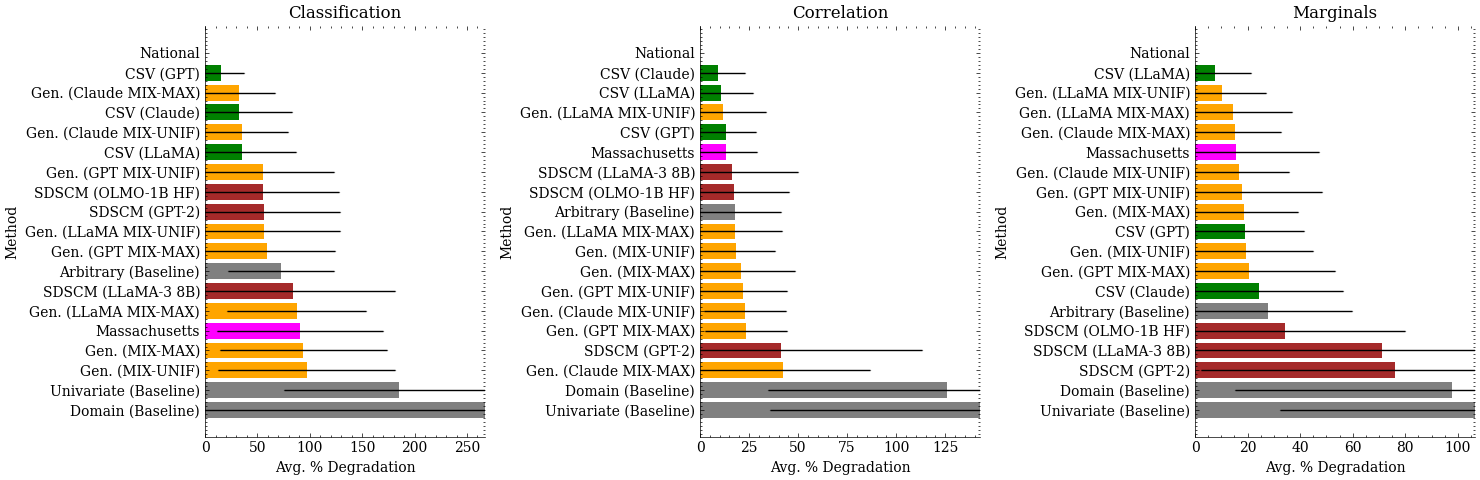

In [56]:
facet_plot_builder(merged_df_acs, acs_method_name_map)

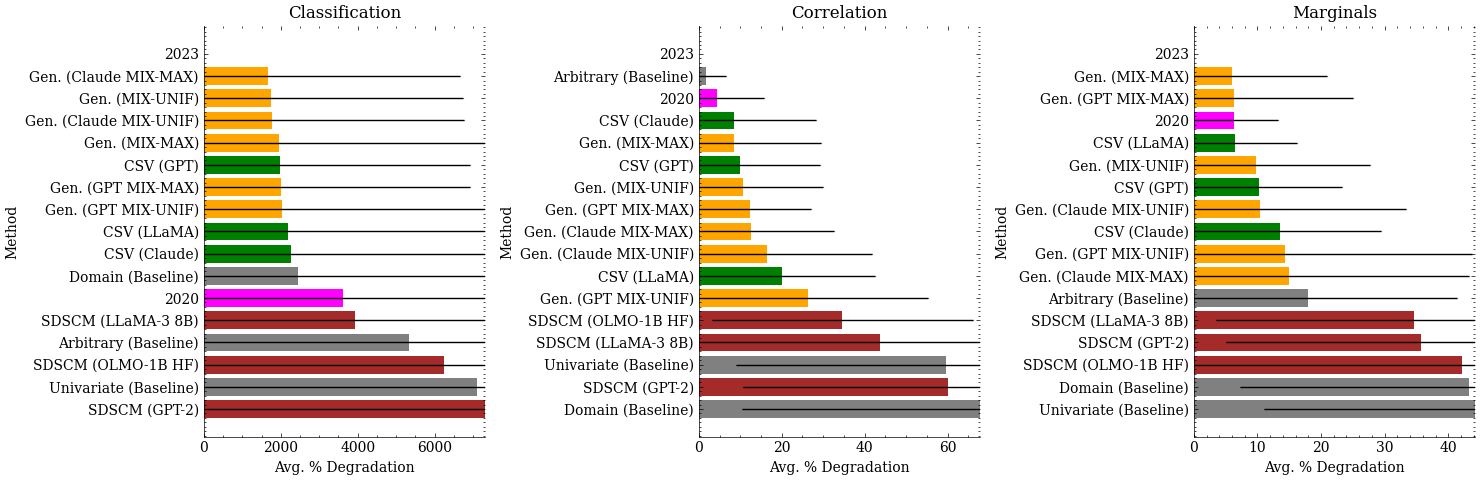

In [57]:
facet_plot_builder(merged_df_edad, edad_method_name_map)

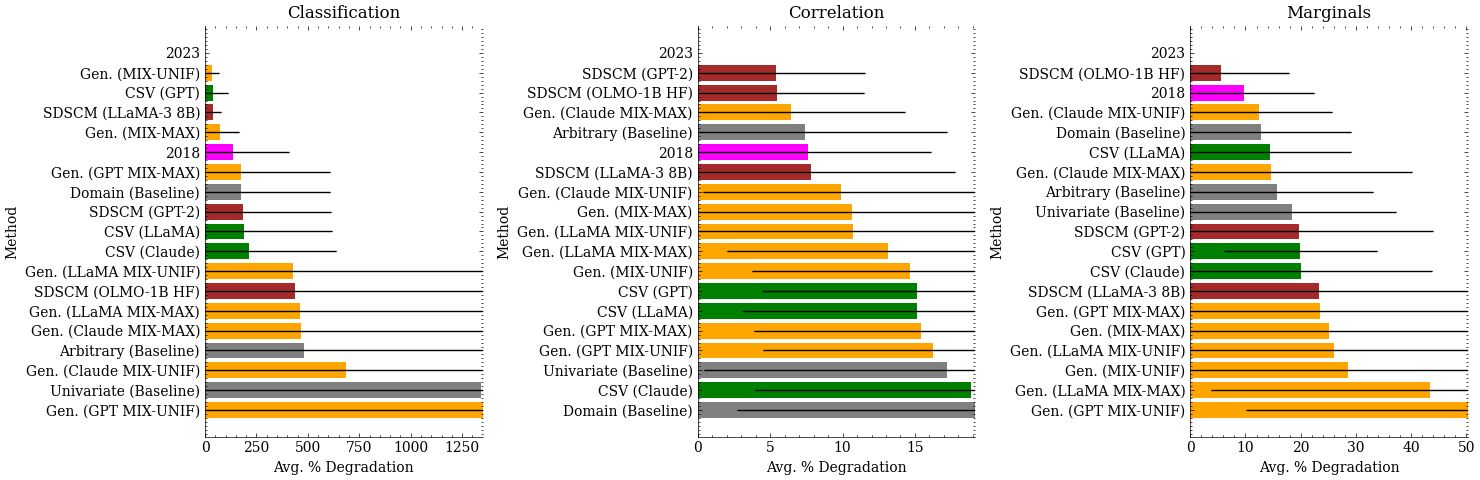

In [58]:
facet_plot_builder(merged_df_we, we_method_name_map)

## pareto frontier analysis

In [30]:
from pandas.plotting import parallel_coordinates

def identify_pareto_frontier(df, metric_columns):
    # check for pareto frontier
    costs = df[metric_columns].values
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            # any point that is dominated by point i is not efficient
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True 
    return is_efficient

def pareto_frontier_analysis_for_df(df):
    agg_df = df.groupby(['dataset_name', 'metric_group'])['pct_degradation_on_ref'].mean().reset_index()

    pivot_df = agg_df.pivot(index='dataset_name', columns='metric_group', values='pct_degradation_on_ref').reset_index()

    pivot_df.columns.name = None
    pivot_df.rename(columns={
        'classification_metrics': 'classification',
        'marginals_metrics': 'marginals',
        'correlation_metrics': 'correlation'
    }, inplace=True)

    pivot_df = pivot_df[~pivot_df['dataset_name'].str.contains('2018')]
    pivot_df = pivot_df[~pivot_df['dataset_name'].str.contains('2023')]
    pivot_df = pivot_df[~pivot_df['dataset_name'].str.contains('national')]
    pivot_df = pivot_df[~pivot_df['dataset_name'].str.contains('massachusetts')]
    
    metric_cols = ['classification', 'marginals', 'correlation']

    pivot_df['pareto'] = identify_pareto_frontier(pivot_df, metric_cols)

    pareto_df = pivot_df[pivot_df['pareto']]
    print()
    print("these are pareto-efficient methods!")
    print(pareto_df)
    print()

    with plt.style.context(['science']):
        plt.rc('text', usetex=False)
        pivot_df['pareto_front'] = pivot_df['pareto'].apply(lambda x: 'pareto front' if x else 'non-pareto')

        plt.figure(figsize=(8, 4))
        pivot_df = pivot_df.sort_values('pareto_front', ascending=False)
        parallel_coordinates(
            pivot_df,
            class_column='pareto_front',
            cols=['classification', 'marginals', 'correlation'],
            color=('blue', 'grey'),
            linewidth=2
        )

        plt.title('Parallel Coordinates Plot (Pareto Frontier)', fontsize=15)
        plt.xlabel('Metric Groups', fontsize=12)
        plt.ylabel('% Degradation', fontsize=12)
        plt.yscale('log')
        plt.legend(title='Pareto Class')
        # rename cols
        plt.xticks(ticks=[0, 1, 2], labels=['Classification', 'Marginals', 'Correlation'])
        plt.grid(True)
        plt.show()



these are pareto-efficient methods!
     dataset_name  classification  correlation  marginals  pareto
3  acs/csv-claude        0.410135     0.090708   0.190554    True
4     acs/csv-gpt        0.188703     0.130271   0.202032    True
5   acs/csv-llama        0.302610     0.105341   0.061804    True



<Figure size 800x400 with 0 Axes>

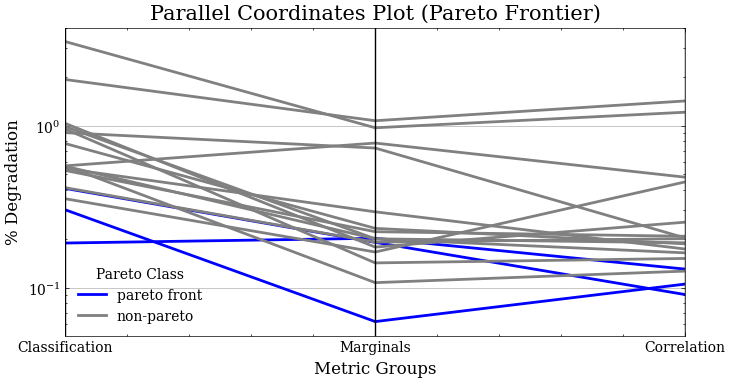

In [31]:
pareto_frontier_analysis_for_df(for_eps_and_method_acs)



these are pareto-efficient methods!
                dataset_name  classification  correlation  marginals  pareto
0                  edad/2020       45.127657     0.044839   0.072582    True
2             edad/arbitrary       63.606997     0.018922   0.178524    True
5            edad/csv-claude       25.447186     0.089040   0.106960    True
6               edad/csv-gpt       22.937310     0.108256   0.065748    True
8           edad/gen-MIX-MAX       24.290106     0.103803   0.074576    True
9          edad/gen-MIX-UNIF       21.932477     0.125437   0.119294    True
10   edad/gen-claude-MIX-MAX       20.713699     0.128092   0.174845    True
11  edad/gen-claude-MIX-UNIF       21.969253     0.169184   0.117276    True
12      edad/gen-gpt-MIX-MAX       22.365549     0.121626   0.067636    True



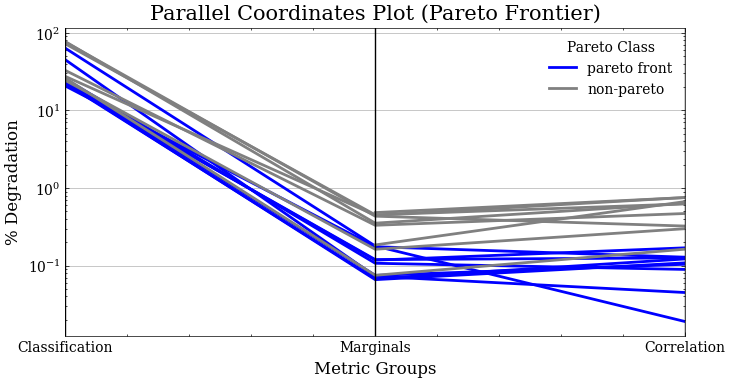

In [32]:
pareto_frontier_analysis_for_df(for_eps_and_method_edad)


these are pareto-efficient methods!
           dataset_name  classification  correlation  marginals  pareto
3    we/baseline_domain        2.102968     0.208090   0.117451    True
6            we/csv-gpt        0.308579     0.142413   0.208085    True
7          we/csv-llama        2.340504     0.145786   0.139841    True
9       we/gen-MIX-UNIF        0.384137     0.136224   0.335866    True
16        we/sdscm-gpt2        2.209941     0.037328   0.188760    True
17  we/sdscm-llama-3-8b        0.495892     0.061436   0.157512    True
18  we/sdscm-olmo-1b-hf        5.442762     0.041778   0.065765    True



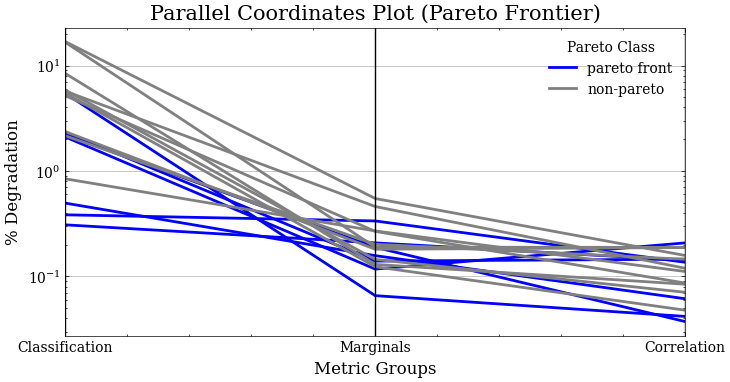

In [33]:
pareto_frontier_analysis_for_df(for_eps_and_method_we)
